In [1]:
####################################################################################
#
# Ptychography: compare OpenCL and CUDA (and CPU) operators results, using a CXI dataset
#
# NOTE: this is mostly for debugging and testing. Mixing the use of CUDA and OpenCL
#       operators is NOT RECOMMENDED, as behaviour heavily relies on underlying
#       code, which can evolve quickly.
#
# (c) ESRF 2019-present
# Authors: Vincent Favre-Nicolin <favre@esrf.fr>
#
####################################################################################
import os

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from skimage.feature import register_translation
from pynx.ptycho import simulation, shape
import numpy as np
import warnings
warnings.simplefilter('ignore')

# Import Ptycho, PtychoData and operators (automatically imports OpenCL or CUDA operators)
from pynx.ptycho import *

# Import CXI runner
from pynx.ptycho.runner.cxi import PtychoRunnerScanCXI
from pynx.ptycho.runner.runner import params_generic as params

# Load explicitely both OpenCL and CUDA operators
import pynx.ptycho.cl_operator as clop
import pynx.ptycho.cu_operator as cuop
import pynx.ptycho.cpu_operator as cpuop

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
##################
# Load CXI data

params['saveprefix']='ResultsScan%04d/Run%04d'
#params['cxifile']='/data/id01/inhouse/favre//201606id01-FZP/201606id01-FZP-S0013.cxi'
params['cxifile']='/Users/vincent/data/201606id01-FZP-S0013.cxi'
params['probe']='gauss,150e-9x200e-9'  # Starting from a simulated probe, here described as gaussian
params['object'] = 'random,0.8,1,0,0.5'
params['verbose'] = 20
params['algorithm'] = "DM**100,probe=1,nbprobe=2"
params['maxframe'] = 256
params['mask'] = 'maxipix'

# Make sure stack size is the same for OpenCL and CUDA
#params['stack_size'] = 16
#cuop.default_processing_unit.set_stack_size(16)
#clop.default_processing_unit.set_stack_size(16)

ws = PtychoRunnerScanCXI(params, 0)
ws.load_scan()  # Load the scan positions (must be done before load_data()
ws.load_data()  # Load all frames from a maxipix detector using CXI/HDF5 data
ws.prepare_processing_unit()

ws.center_crop_data()  # Auto-crop the data
ws.prepare()  # This will prepare the initial object

# Make sure stack size is the same for OpenCL and CUDA
n = len(ws.x)
params['stack_size'] = len(ws.x)
cuop.default_processing_unit.set_stack_size(len(ws.x))
clop.default_processing_unit.set_stack_size(len(ws.x))


MAXFRAME: only using first 256 frames
Reading 256 frames from CXI-HDF5 file: 0.20.40.60.80.100.120.140.160.180.200.220.240
Time to read all frames:  0.8s [81.61 Mpixel/s]
Ptycho runner: preparing processing unit
Computing speed for available CUDA GPU [ranking by global memory bandwidth]:
                                         GeForce GTX 1080 Ti:   10 Gb,   326 Gbytes/s
Using CUDA GPU: GeForce GTX 1080 Ti
Using CUDA GPU=> setting large stack size (128) (override with stack_size=N)
Center of diffraction: X=206.74 Y=209.14
Largest prime number acceptable for FFT size: 13
Final iobs data size after cropping / centering / rebinning: (256, 400, 400)
E= 7.989keV, zdetector= 1.386m, pixel size= 55.00um, pixel size(object)=   9.8nm
Using random object type with amplitude range:  0.80- 1.00 and phase range:  0.00- 0.50


In [3]:
# Initial optimisation
ws.run()  

# Get Ptycho object
p = ws.p

# Keep copies of object and probe to restore later
obj = p.get_obj()
probe = p.get_probe()


 #################################################################################################### 
# 
# Scan:   0 Run: 37
#
 ####################################################################################################
Simulating object: random
Making obj: (612, 616) 608 620
Simulating probe: gauss
ScaleObjProbe: 1.0 339362.12 196337.54082613153 258126.95533793105 0.760623944185419

 #################################################################################################### 
# 
# Scan:   0 Run: 37 , Algorithm: nbprobe=2
#
 ####################################################################################################

 #################################################################################################### 
# 
# Scan:   0 Run: 37 , Algorithm: probe=1
#
 ####################################################################################################

 ###############################################################################################

## Basic Fourier scaling test
The scaling for FFT is different for CUDA, OpenCL and CPU (numpy) versions. 

Scale factors must be adjusted to make sure object and probe are correctly scaled with respect to the observed intensity.
This is done automatically, notably in PropagateApplyAmplitude(), but good to keep in mind when developing new operators.

In [4]:
p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.ObjProbe2Psi() * p
v0 =  (np.abs(p._cl_psi.get())**2).sum()
p = clop.FT(scale=False) * p
v1 =  (np.abs(p._cl_psi.get())**2).sum()
p = clop.IFT(scale=False) * p
v2 =  (np.abs(p._cl_psi.get())**2).sum()
print("OpenCL FT scaling (L2 norm): FT  *%12.4f  iFT  /%12.4f   ObjProbe**2/Iobs=%12.4f"
      % (v1 / v0, v1 / v2, v0/p.data.iobs.sum()))

# CUDA
p = cuop.ObjProbe2Psi() * p
v0 =  (np.abs(p._cu_psi.get())**2).sum()
p = cuop.FT(scale=False) * p
v1 =  (np.abs(p._cu_psi.get())**2).sum()
p = cuop.IFT(scale=False) * p
v2 =  (np.abs(p._cu_psi.get())**2).sum()
print("CUDA   FT scaling (L2 norm): FT  *%12.4f  iFT  *%12.4f   ObjProbe**2/Iobs=%12.4f"
      % (v1 / v0, v2 / v1, v0/p.data.iobs.sum()))

# CPU
p = cpuop.ObjProbe2Psi() * p
v0 =  (np.abs(p._psi)**2).sum()
p = cpuop.FT(scale=True) * p
v1 =  (np.abs(p._psi)**2).sum()
p = cpuop.IFT(scale=True) * p
v2 =  (np.abs(p._psi)**2).sum()
print("CPU    FT scaling (L2 norm): FT  *%12.4f  iFT  /%12.4f  [scale=True] ObjProbe**2/Iobs=%12.4f" 
      % (v1 / v0, v1 / v2, v0/p.data.iobs.sum()))


OpenCL FT scaling (L2 norm): FT  * 159996.5312  iFT  / 159996.5312   ObjProbe**2/Iobs=      0.8624
CUDA   FT scaling (L2 norm): FT  * 159996.4219  iFT  * 160003.0625   ObjProbe**2/Iobs=      0.8624
CPU    FT scaling (L2 norm): FT  *      1.0000  iFT  /      1.0000  [scale=True] ObjProbe**2/Iobs=      0.8624



## ObjProbe2Psi

<IPython.core.display.Javascript object>


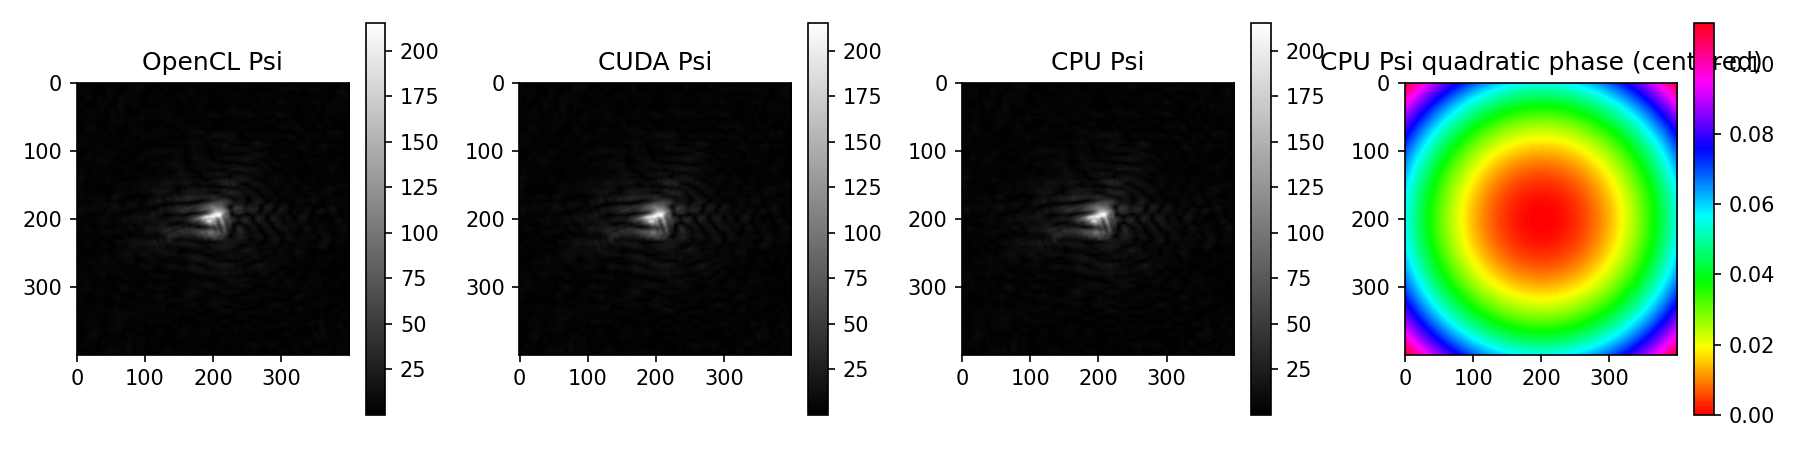

/Users/vincent/dev/py38-env/lib/python3.8/site-packages/skimage/feature/__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/Users/vincent/dev/py38-env/lib/python3.8/site-packages/skimage/feature/__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')


(array([0., 0.]), 0.0003984370697838786, 7.366131e-08)
(array([0., 0.]), 0.0003984370697838786, -5.1457194e-10)
True
True


In [5]:
plt.figure(figsize=(12,3))

p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.ObjProbe2Psi() * p
plt.subplot(141)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])), cmap='gray')
plt.title('OpenCL Psi')
plt.colorbar()

# CUDA
p = cuop.ObjProbe2Psi() * p
plt.subplot(142)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])), cmap='gray')
plt.title('CUDA Psi')
plt.colorbar()

# CPU
p = cpuop.ObjProbe2Psi() * p
plt.subplot(143)
plt.imshow(fftshift(abs(p._psi[0,0,0])), cmap='gray')
plt.title('CPU Psi')
plt.colorbar()

# Check shift between ObjProbe
print(register_translation(p._cl_psi.get()[0,0,0], p._cu_psi.get()[0,0,0]))
print(register_translation(p._cl_psi.get()[0,0,0], p._psi[0,0,0]))

atol = np.abs(p._cl_psi.get()).max() * 1e-4
print(np.allclose(p._cl_psi.get(), p._cu_psi.get(), atol=atol, rtol=1e-3))
print(np.allclose(p._psi, p._cu_psi.get(), atol=atol, rtol=1e-4))


p.set_probe(abs(probe))
p.set_obj(abs(obj))
p = cpuop.ObjProbe2Psi() * p
plt.subplot(144)
plt.imshow(np.angle(p._cpu_tmp_quad_phase[0]), cmap='hsv')
plt.title('CPU Psi quadratic phase (centered)')
plt.colorbar()

plt.tight_layout()

## FT * ObjProbe2Psi, and scale comparison with Iobs

<IPython.core.display.Javascript object>


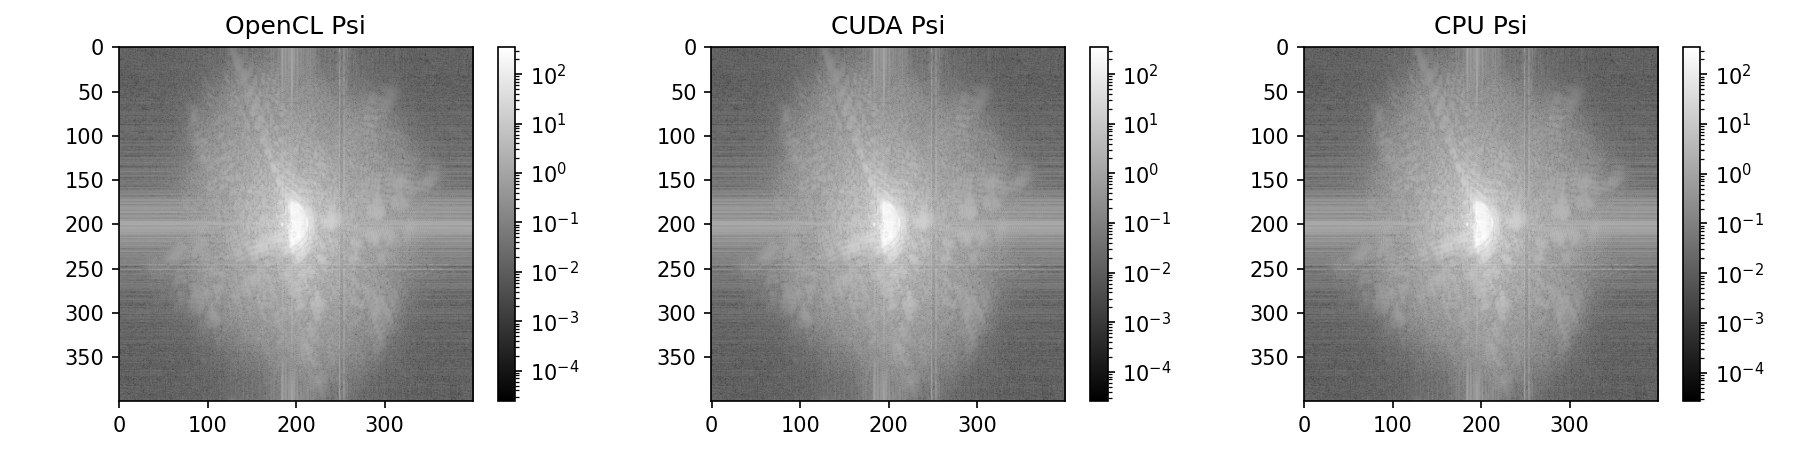

OpenCL: <Icalc>/<Iobs>= 137979.25000
CUDA: <Icalc>/<Iobs>= 137979.15625
CPU: <Icalc>/<Iobs>=      0.86236
True
True


In [9]:
plt.figure(figsize=(12,3))

# Scale factors
scu = cuop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)[0]
scl = clop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)[0]

p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.FT(scale=False) * clop.ObjProbe2Psi() * p
plt.subplot(131)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])) * scl, cmap='gray', norm=colors.LogNorm())
plt.title('OpenCL Psi')
plt.colorbar()
print('OpenCL: <Icalc>/<Iobs>= %12.5f' % ((abs(p._cl_psi.get())**2).sum() / p.data.iobs.sum()))

# CUDA
p = cuop.FT(scale=False) * cuop.ObjProbe2Psi() * p
plt.subplot(132)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])) * scu, cmap='gray', norm=colors.LogNorm())
plt.title('CUDA Psi')
plt.colorbar()
print('CUDA: <Icalc>/<Iobs>= %12.5f' % ((abs(p._cu_psi.get())**2).sum() / p.data.iobs.sum()))

# CPU
p = cpuop.FT(scale=True) * cpuop.ObjProbe2Psi() * p
plt.subplot(133)
plt.imshow(fftshift(abs(p._psi[0,0,0])), cmap='gray', norm=colors.LogNorm())
plt.title('CPU Psi')
plt.colorbar()
print('CPU: <Icalc>/<Iobs>= %12.5f' % ((abs(p._psi)**2).sum() / p.data.iobs.sum()))

plt.tight_layout()

atol = np.abs(p._cu_psi.get()).max() * 1e-4
print(np.allclose(p._cl_psi.get() * scl, p._cu_psi.get() * scu, atol=atol, rtol=1e-4))
print(np.allclose(p._psi, p._cu_psi.get() * scu, atol=atol, rtol=1e-4))


## Amplitude projection (manual)

<IPython.core.display.Javascript object>


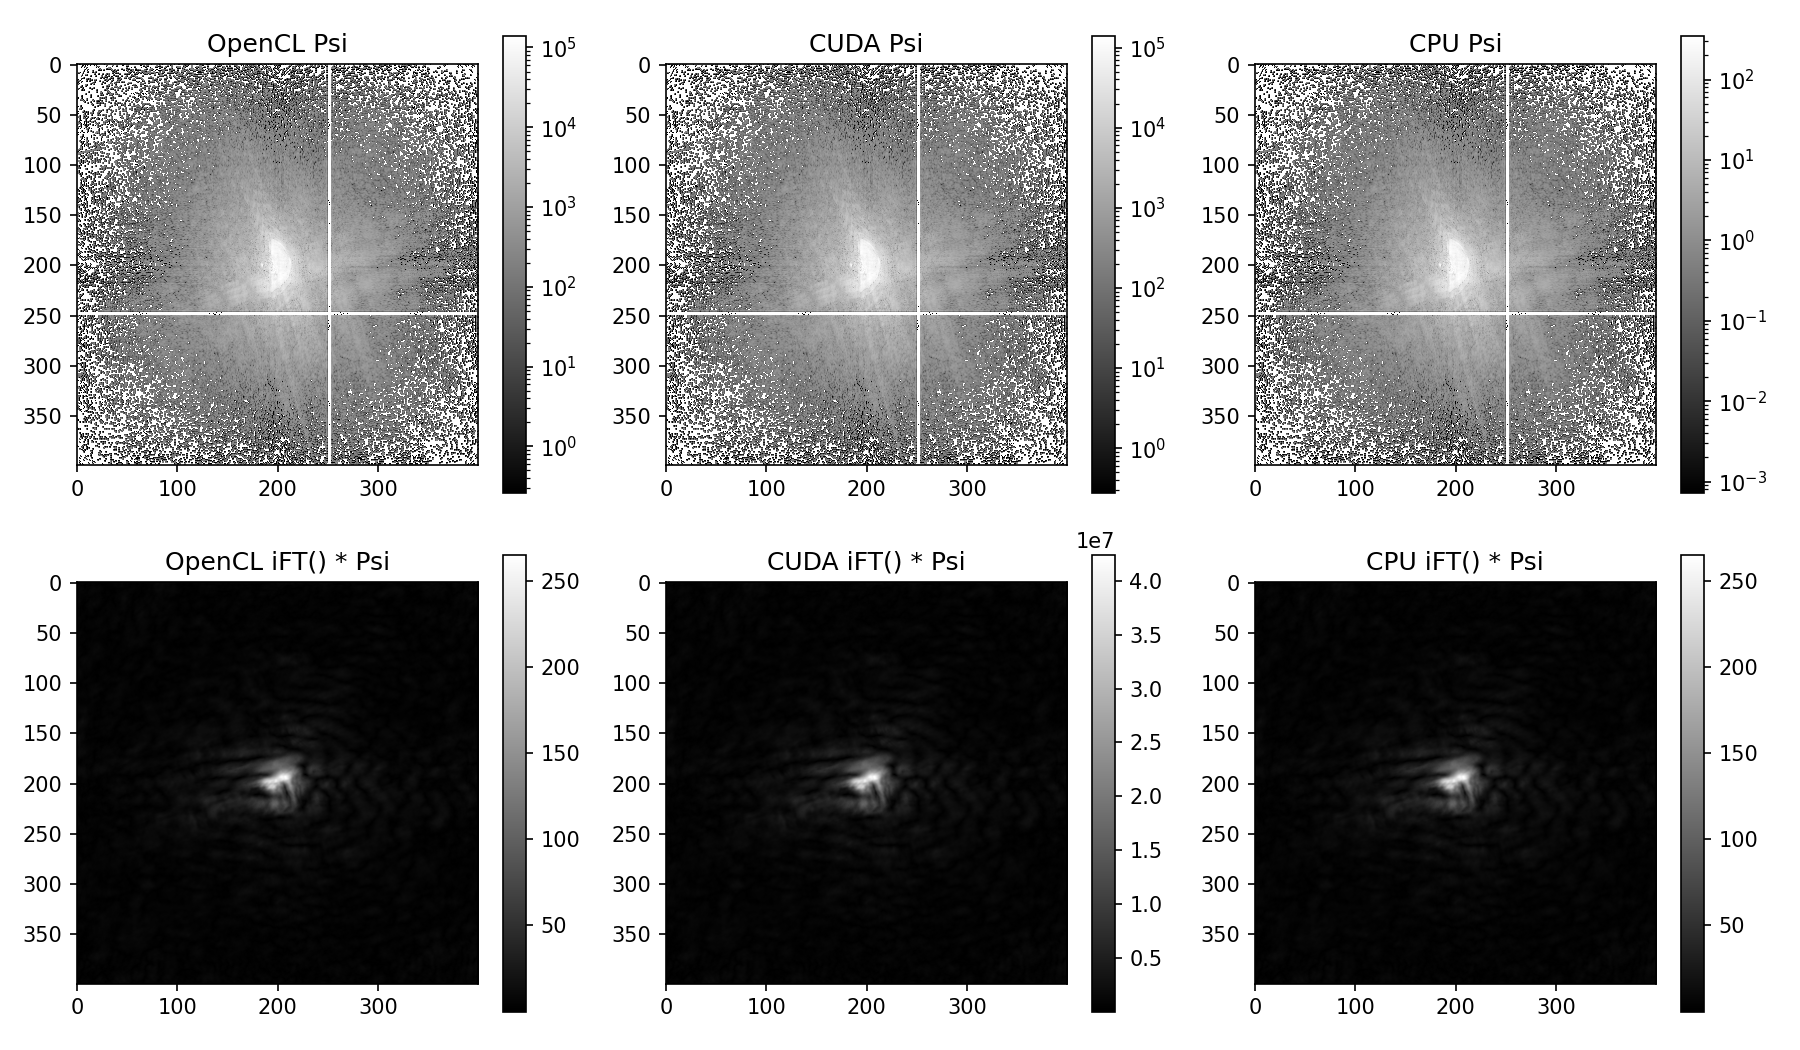

In [11]:
plt.figure(figsize=(12,7))

scu = cuop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)
scl = clop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)

p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.ApplyAmplitude(scale_in=scl[0], scale_out=scl[1]) * clop.FT(scale=False) * clop.ObjProbe2Psi() * p
plt.subplot(231)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])), cmap='gray', norm=colors.LogNorm())
plt.title('OpenCL Psi')
plt.colorbar()
p = clop.IFT(scale=False) * p
plt.subplot(234)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])), cmap='gray')
plt.title('OpenCL iFT() * Psi')
plt.colorbar()

# CUDA
p = cuop.ApplyAmplitude(scale_in=scl[0], scale_out=scl[1]) * cuop.FT(scale=False) * cuop.ObjProbe2Psi() * p
plt.subplot(232)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])), cmap='gray', norm=colors.LogNorm())
plt.title('CUDA Psi')
plt.colorbar()
p = cuop.IFT(scale=False) * p
plt.subplot(235)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])), cmap='gray')
plt.title('CUDA iFT() * Psi')
plt.colorbar()

# CPU
p = cpuop.ApplyAmplitude()* cpuop.FT() * cpuop.ObjProbe2Psi() * p
plt.subplot(233)
plt.imshow(fftshift(abs(p._psi[0,0,0])), cmap='gray', norm=colors.LogNorm())
plt.title('CPU Psi')
plt.colorbar()
p = cpuop.IFT() * p
plt.subplot(236)
plt.imshow(fftshift(abs(p._psi[0,0,0])), cmap='gray')
plt.title('CPU iFT() * Psi')
plt.colorbar()

plt.tight_layout()

## Amplitude projection

<IPython.core.display.Javascript object>


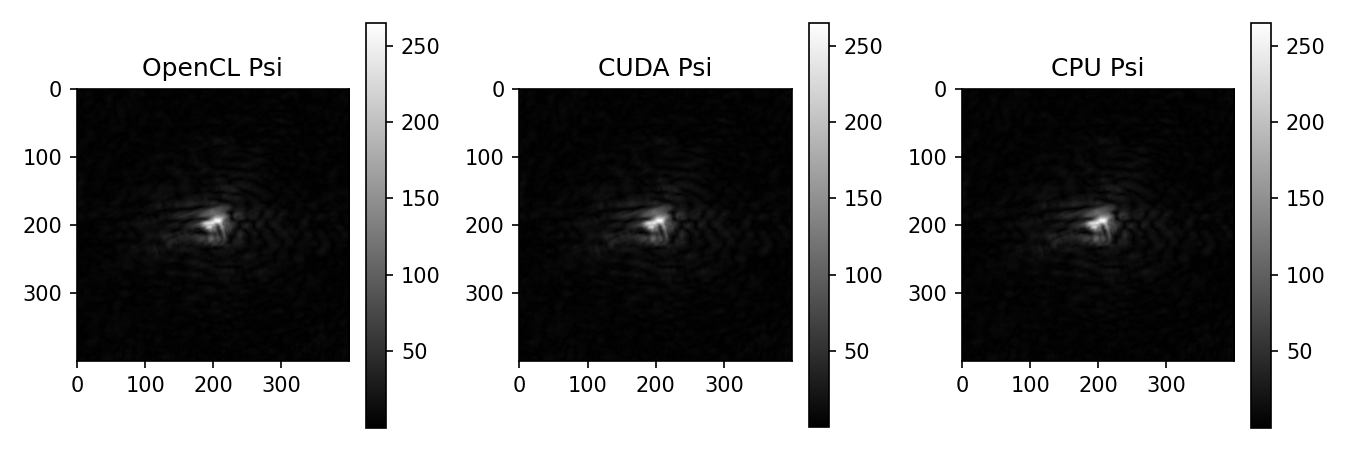

In [12]:
plt.figure(figsize=(9,3))

p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.PropagateApplyAmplitude() * clop.ObjProbe2Psi() * p
plt.subplot(131)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])), cmap='gray')
plt.title('OpenCL Psi')
plt.colorbar()

# CUDA
p = cuop.PropagateApplyAmplitude() * cuop.ObjProbe2Psi() * p
plt.subplot(132)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])), cmap='gray')
plt.title('CUDA Psi')
plt.colorbar()

# CPU
p = cpuop.PropagateApplyAmplitude() * cpuop.ObjProbe2Psi() * p
plt.subplot(133)
plt.imshow(fftshift(abs(p._psi[0,0,0])), cmap='gray')
plt.title('CPU Psi')
plt.colorbar()

plt.tight_layout()

## Log-likelihood

In [15]:
scu = cuop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)
scl = clop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)

# OpenCL
pu = clop.default_processing_unit
i = p._cl_stack_i
nb_mode = np.int32(p._probe.shape[0] * p._obj.shape[0])
nb_psi = p._cl_obs_v[i].npsi
nxy = np.int32(p._probe.shape[-2] * p._probe.shape[-1])
nxystack = np.int32(pu.cl_stack_size * nxy)
p = clop.FT(scale=False) * clop.ObjProbe2Psi() * p
llk = pu.cl_llk(p._cl_obs_v[i].cl_obs[:nb_psi], p._cl_psi, p._cl_background,
                nb_mode, nxy, nxystack, scl[0], wait_for=pu.ev).get()
p.llk_poisson = llk['x']
p.llk_gaussian = llk['y']
p.llk_euclidian = llk['z']
p.nb_photons_calc = llk['w']

print("OpenCL LLKp=", p.llk_poisson / p.nb_obs)

# CUDA
p.set_probe(probe)
p.set_obj(obj)
pu = cuop.default_processing_unit
i = 0
p = cuop.SelectStack(i) * p
nb_mode = np.int32(p._probe.shape[0] * p._obj.shape[0])
nb_psi = p._cu_obs_v[i].npsi
nxy = np.int32(p._probe.shape[-2] * p._probe.shape[-1])
nxystack = np.int32(pu.cu_stack_size * nxy)
s = np.float32(1)
s = 1#1 / np.sqrt(p._cu_psi[0, 0, 0].size)  # Compensates for FFT scaling ??
p = cuop.FT(scale=False) * cuop.ObjProbe2Psi() * p
llk = pu.cu_llk(p._cu_obs_v[i].cu_obs[:nb_psi], p._cu_psi, p._cu_background,
                nb_mode, nxy, nxystack, scu[0]).get()
p.llk_poisson = llk['a']
p.llk_gaussian = llk['b']
p.llk_euclidian = llk['c']
p.nb_photons_calc = llk['d']
print("CUDA   LLKp=", p.llk_poisson / p.nb_obs)

# CPU
p.set_probe(probe)
p.set_obj(obj)
p = cpuop.FT(scale=True) * cpuop.ObjProbe2Psi() * p
iobs = p.data.iobs.flatten()
icalc = (np.abs(p._psi) ** 2).sum(axis=(0, 1)).flatten()

llk = np.zeros(iobs.shape, dtype=np.float32)
idx = np.where(iobs > 0)
llk[idx] = np.take(icalc - iobs + iobs * np.log(iobs / icalc), idx)
idx = np.where(iobs == 0)
llk[idx] = np.take(icalc, idx)
p.llk_poisson = llk.sum()
p.llk_gaussian = ((iobs - icalc) ** 2 / (iobs + 1)).sum()
p.llk_euclidian = 4 * ((np.sqrt(abs(iobs)) - np.sqrt(icalc)) ** 2).sum()

print("CPU    LLKp=", p.llk_poisson / p.nb_obs)


OpenCL LLKp= 17.541584375
CUDA   LLKp= 17.657009375
CPU    LLKp= 17.6569953125


## Object and probe update

<IPython.core.display.Javascript object>


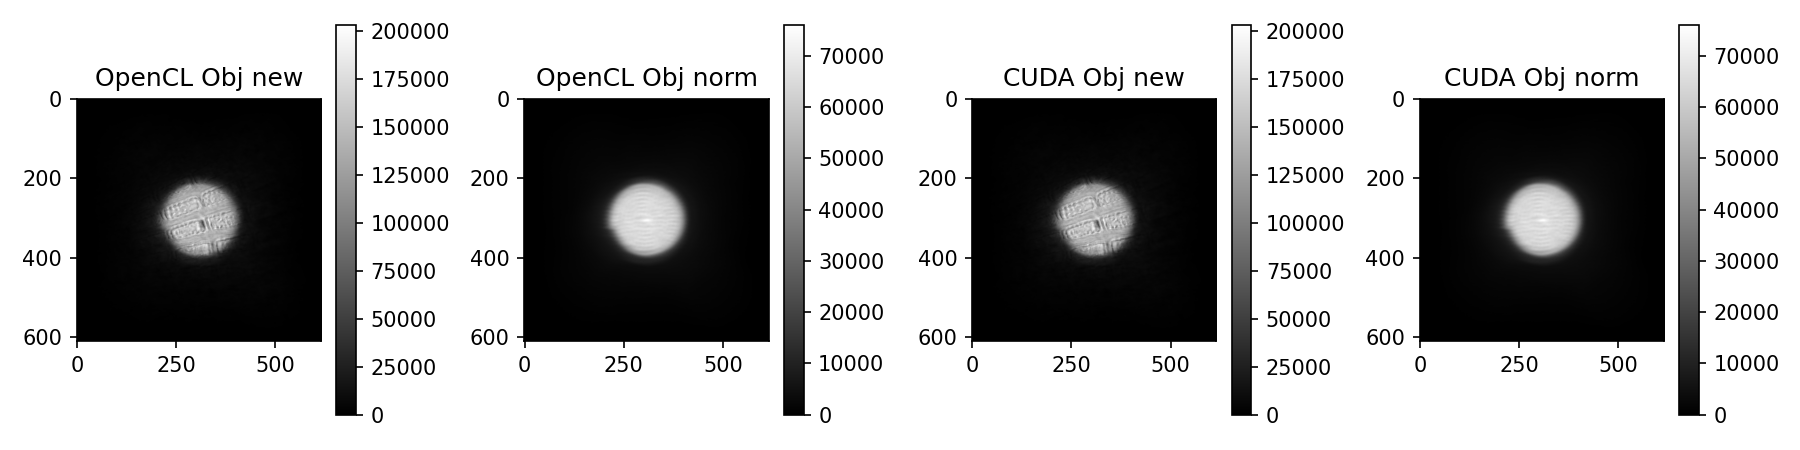

True
True


In [16]:
plt.figure(figsize=(12,3))

p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.Psi2Obj() * clop.Psi2Probe() * clop.PropagateApplyAmplitude() * clop.ObjProbe2Psi() * p
plt.subplot(141)
plt.imshow(abs(p._cl_obj_new.get().sum(axis=(0))), cmap='gray')
plt.title('OpenCL Obj new')
plt.colorbar()
plt.subplot(142)
plt.imshow(p._cl_obj_norm.get(), cmap='gray')
plt.title('OpenCL Obj norm')
plt.colorbar()

# CUDA
p = cuop.Psi2Obj() * cuop.Psi2Probe() * cuop.PropagateApplyAmplitude() * cuop.ObjProbe2Psi() * p
plt.subplot(143)
plt.imshow(abs(p._cu_obj_new.get()[0]), cmap='gray')
plt.title('CUDA Obj new')
plt.colorbar()
plt.subplot(144)
plt.imshow(abs(p._cu_obj_norm.get()), cmap='gray')
plt.title('CUDA Obj norm')
plt.colorbar()

atol = np.abs(p._cu_obj_new.get()).max() * 1e-4
print(np.allclose(p._cl_obj_new.get().sum(axis=(0)), p._cu_obj_new.get().sum(axis=0), atol=atol, rtol=1e-4))
atol = np.abs(p._cu_obj_norm.get()).max() * 1e-4
print(np.allclose(p._cl_obj_norm.get(), p._cu_obj_norm.get(), atol=atol, rtol=1e-4))

if False:
    # CPU
    p = cpuop.Psi2ObjProbe(True,True) * cpuop.PropagateApplyAmplitude() * cpuop.ObjProbe2Psi() * p
    plt.subplot(133)
    plt.imshow(abs(p._psi[0,0,0]), cmap='gray')
    plt.title('CPU Psi')
    plt.colorbar()

plt.tight_layout()

## Gradient calculation (step 1 : 1-Iobs/Icalc) * Psi)

<IPython.core.display.Javascript object>


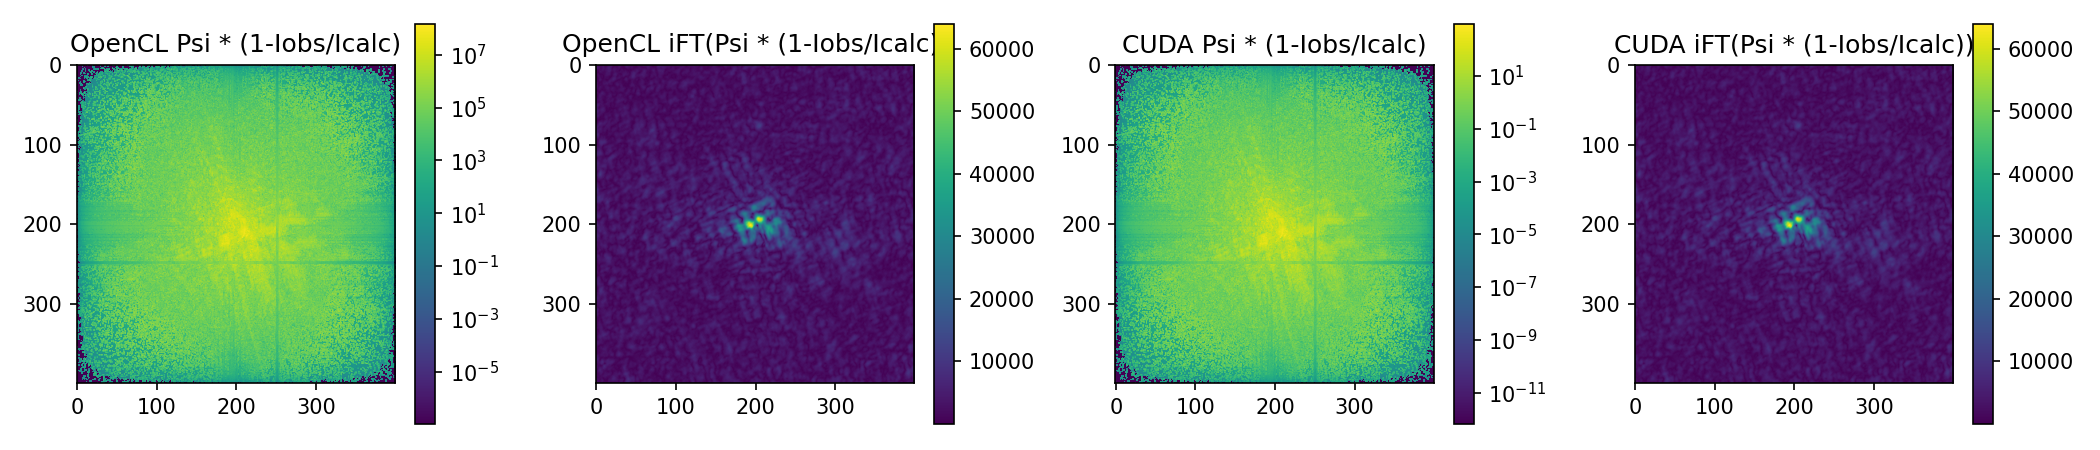

OpenCL calc, obs / sum(): 1.566311e+15 / 1.135179e+10 = 1.379792e+05
  CUDA calc, obs / sum(): 1.566310e+15 / 1.135179e+10 = 1.379792e+05
True


In [21]:
scu = cuop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)
scl = clop.default_processing_unit.fft_scale(p._psi.shape, ndim=2)

# Manual Psi * (1-Iobs/Icalc)
plt.figure(figsize=(14,3))

ny = np.int32(p._probe.shape[-2])
nx = np.int32(p._probe.shape[-1])
nb_probe = np.int32(p._probe.shape[0])
nb_obj = np.int32(p._obj.shape[0])
nb_mode = np.int32(nb_obj * nb_probe)
nyo = np.int32(p._obj.shape[-2])
nxo = np.int32(p._obj.shape[-1])
first_pass = np.int8(1)
nxy = np.int32(ny * nx)
hann_filter = np.int8(1)
f = np.float32(np.pi / (p.data.wavelength * p.data.detector_distance))

# openCL
p.set_probe(probe)
p.set_obj(obj)
pu = clop.default_processing_unit
i = p._cl_stack_i
i0 = p._cl_obs_v[i].i

nb_psi = np.int32(p._cl_obs_v[i].npsi)
nxystack = np.int32(pu.cl_stack_size * nx * ny)
p._cl_background_grad = p._cl_background.copy()
p._cl_background_grad.fill(np.float32(0))

p = clop.ObjProbe2Psi() * p
p = clop.FT(scale=False) * p

print("OpenCL calc, obs / sum(): %8e / %8e = %8e" % ((np.abs(p._cl_psi.get())**2).sum(), p._cl_obs_v[i].cl_obs.get().sum(), (np.abs(p._cl_psi.get())**2).sum() / p._cl_obs_v[i].cl_obs.get().sum()))
pu.cl_grad_poisson_fourier(p._cl_obs_v[i].cl_obs[0], p._cl_psi, p._cl_background, p._cl_background_grad,
                           nb_mode, nx, ny, nxystack, nb_psi, hann_filter, scl[0], scl[1], p._cl_scale[i0:i0 + nb_psi])
plt.subplot(141)
plt.imshow(abs(np.fft.fftshift(p._cl_psi.get()[0,0,0])), norm=colors.LogNorm())
plt.title('OpenCL Psi * (1-Iobs/Icalc)')
plt.colorbar()

p = clop.IFT(scale=False) * p

plt.subplot(142)
plt.imshow(abs(np.fft.fftshift(p._cl_psi.get()[0,0,0])))
plt.title('OpenCL iFT(Psi * (1-Iobs/Icalc))')
plt.colorbar()

# CUDA
p.set_probe(probe)
p.set_obj(obj)
i = p._cu_stack_i

pu = cuop.default_processing_unit
nb_psi = p._cu_obs_v[i].npsi
nxystack = np.int32(pu.cu_stack_size * nxy)
p._cu_background_grad = p._cu_background.copy()
p._cu_background_grad.fill(np.float32(0))

p = cuop.ObjProbe2Psi() * p
p = cuop.FT(scale=False) * p
print("  CUDA calc, obs / sum(): %8e / %8e = %8e" % ((np.abs(p._cu_psi.get())**2).sum(), p._cu_obs_v[i].cu_obs.get().sum(), (np.abs(p._cu_psi.get())**2).sum() / p._cu_obs_v[i].cu_obs.get().sum()))
pu.cu_grad_poisson_fourier(p._cu_obs_v[i].cu_obs[0], p._cu_psi, p._cu_background, p._cu_background_grad,
                           nb_mode, nx, ny, nxystack, nb_psi, hann_filter, scu[0], scu[1])

plt.subplot(143)
plt.imshow(abs(np.fft.fftshift(p._cu_psi.get()[0,0,0])), norm=colors.LogNorm())
plt.title('CUDA Psi * (1-Iobs/Icalc)')
plt.colorbar()

p = cuop.IFT(scale=False) * p

plt.subplot(144)
plt.imshow(abs(np.fft.fftshift(p._cu_psi.get()[0,0,0])))
plt.title('CUDA iFT(Psi * (1-Iobs/Icalc))')
plt.colorbar()


if False:
    # CPU
    plt.subplot(133)
    p.set_probe(probe)
    p.set_obj(obj)
    p = cpuop.Propagate(forward=True) * cpuop.ObjProbe2Psi() * p
    print("CPU calc, obs / sum(): %8e / %8e = %8e" % ((np.abs(p._psi)**2).sum(), p.data.iobs.sum(), (np.abs(p._psi)**2).sum() / p.data.iobs.sum()))
    calc = (abs(p._psi) ** 2).sum(axis=(0, 1))
    p._psi *= (1 - p.data.iobs / calc * s*s) * (p.data.iobs >= 0)  # with broadcasting
    p = cpuop.Propagate(forward=False) * p

    plt.imshow(abs(np.fft.fftshift(p._psi[0,0,0])))
    plt.title('CPU Psi')
    plt.colorbar()

plt.tight_layout()

print(np.allclose(p._cl_psi.get(), p._cu_psi.get(), rtol=1e-3, atol=np.abs(p._cl_psi.get()).max()*1e-3))
# print(np.allclose(p._cl_psi.get(), p._psi, rtol=1e-2, atol=np.abs(p._cl_psi.get()).max()*1e-2))  # Not sure why there remains a difference

## Gradient calculation

<IPython.core.display.Javascript object>


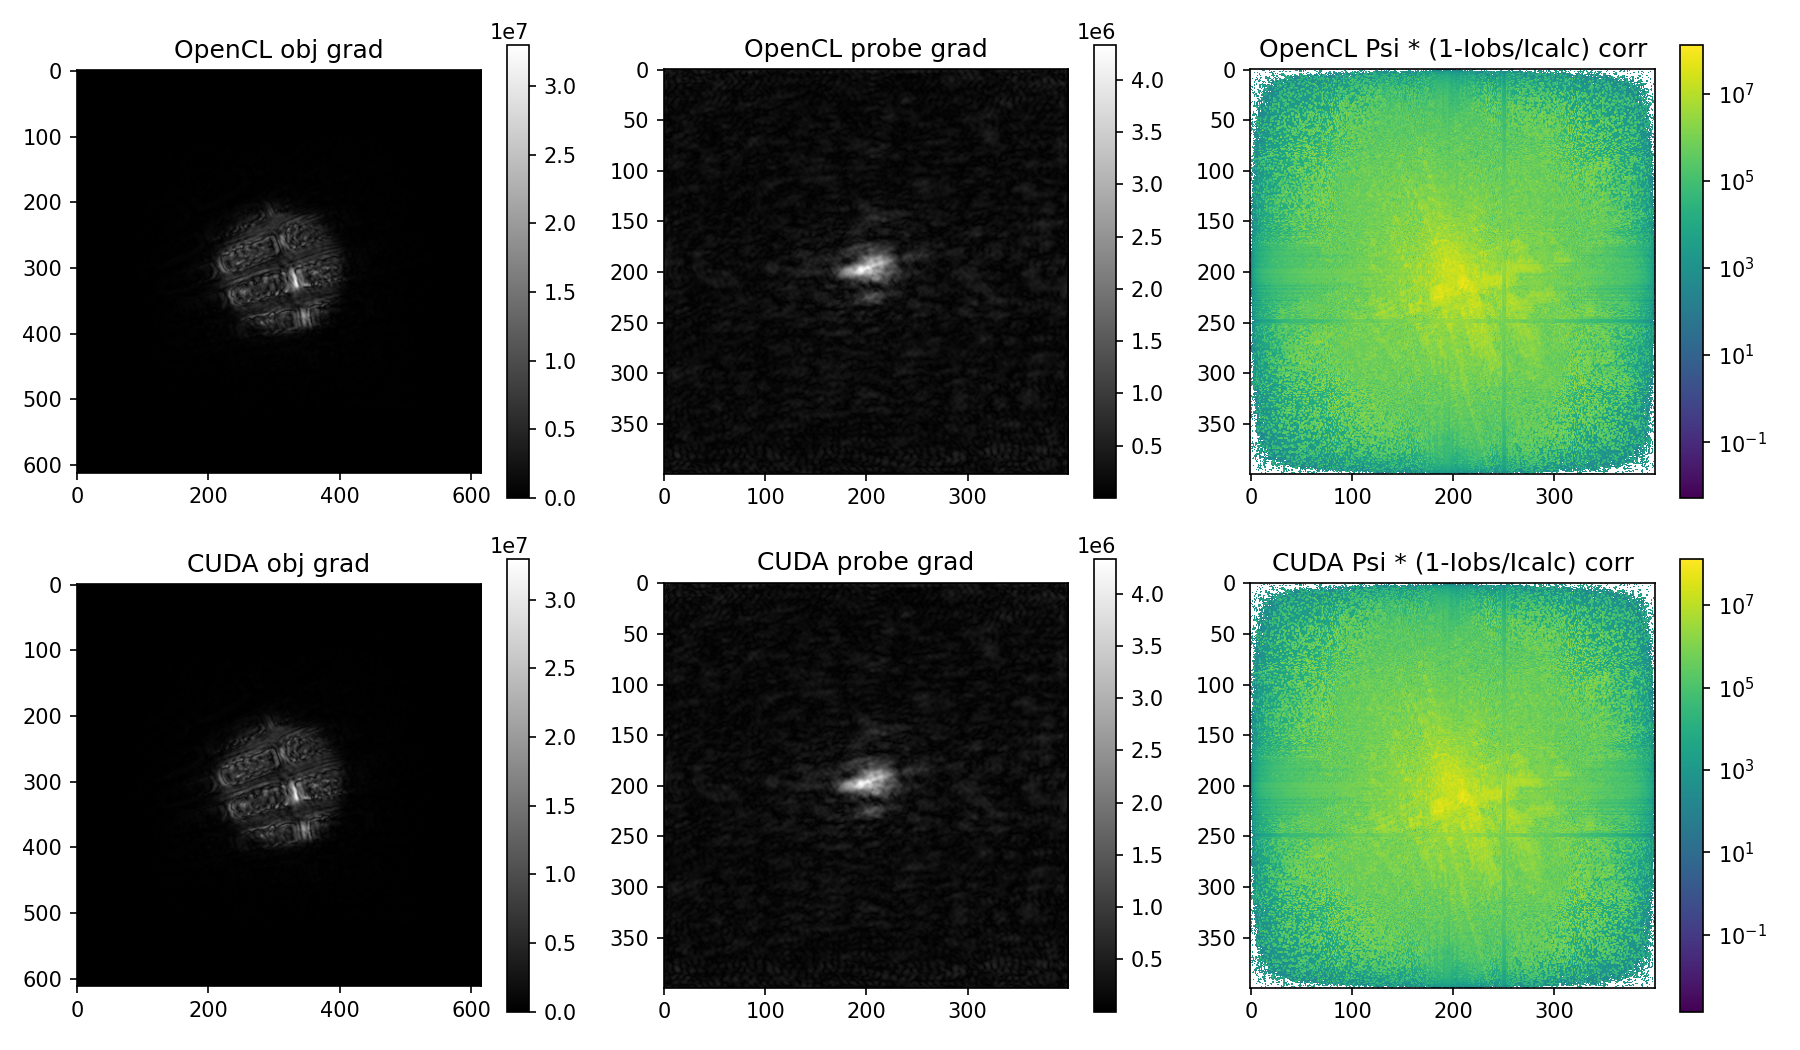

True
True


In [23]:
plt.figure(figsize=(12,7))

# OpenCL
p.set_probe(probe)
p.set_obj(obj*1.1)
p._cl_obj_grad = clop.cla.zeros(clop.default_processing_unit.cl_queue, p._obj.shape, np.complex64)
p._cl_probe_grad = clop.cla.zeros(clop.default_processing_unit.cl_queue, p._probe.shape, np.complex64)
#p = clop.Grad(update_object=True, update_probe=True) * p
p = clop.FT(scale=False) * clop.Grad(update_object=True, update_probe=True) * p
cl_obj_grad = p._cl_obj_grad.get()
cl_probe_grad = p._cl_probe_grad.get()
cl_psi = p._cl_psi.get()
plt.subplot(231)
plt.imshow(abs(cl_obj_grad[0]), cmap='gray')
plt.title('OpenCL obj grad')
plt.colorbar()
plt.subplot(232)
plt.imshow(abs(cl_probe_grad[0]), cmap='gray')
plt.title('OpenCL probe grad')
plt.colorbar()
plt.subplot(233)
plt.imshow(abs(np.fft.fftshift(cl_psi[0,0,0])), norm=colors.LogNorm())
plt.title('OpenCL Psi * (1-Iobs/Icalc) corr')
plt.colorbar()

# CUDA
p.set_probe(probe)
p.set_obj(obj*1.1)
p._cu_obj_grad = cuop.cua.zeros_like(p._cu_obj)
p._cu_probe_grad = cuop.cua.zeros_like(p._cu_probe)
#p = cuop.Grad(update_object=True, update_probe=True) * p
p = cuop.FT(scale=False) * cuop.Grad(update_object=True, update_probe=True) * p
cu_obj_grad = p._cu_obj_grad.get()
cu_probe_grad = p._cu_probe_grad.get()
cl_psi = p._cu_psi.get()
plt.subplot(234)
plt.imshow(abs(cu_obj_grad[0]), cmap='gray')
plt.title('CUDA obj grad')
plt.colorbar()
plt.subplot(235)
plt.imshow(abs(cu_probe_grad[0]), cmap='gray')
plt.title('CUDA probe grad')
plt.colorbar()
plt.subplot(236)
plt.imshow(abs(np.fft.fftshift(cl_psi[0,0,0])), norm=colors.LogNorm())
plt.title('CUDA Psi * (1-Iobs/Icalc) corr')
plt.colorbar()

plt.tight_layout()
plt.draw()
plt.pause(0.01)

r = 1e-4
# Objet gradient differs a bit probably due to different operation order (atomic add on for CUDA)
print(np.allclose(p._cl_obj_grad.get(), p._cu_obj_grad.get(), rtol=r, atol=np.abs(p._cl_obj_grad.get()).max()*r))
print(np.allclose(p._cl_probe_grad.get(), p._cu_probe_grad.get(), rtol=r, atol=np.abs(p._cl_probe_grad.get()).max()*r))

#plt.figure()
#plt.imshow(np.abs(p._cl_obj_grad.get()[0]/p._cu_obj_grad.get()[0]), vmin=0.99,vmax=1.01)

## AP

<IPython.core.display.Javascript object>


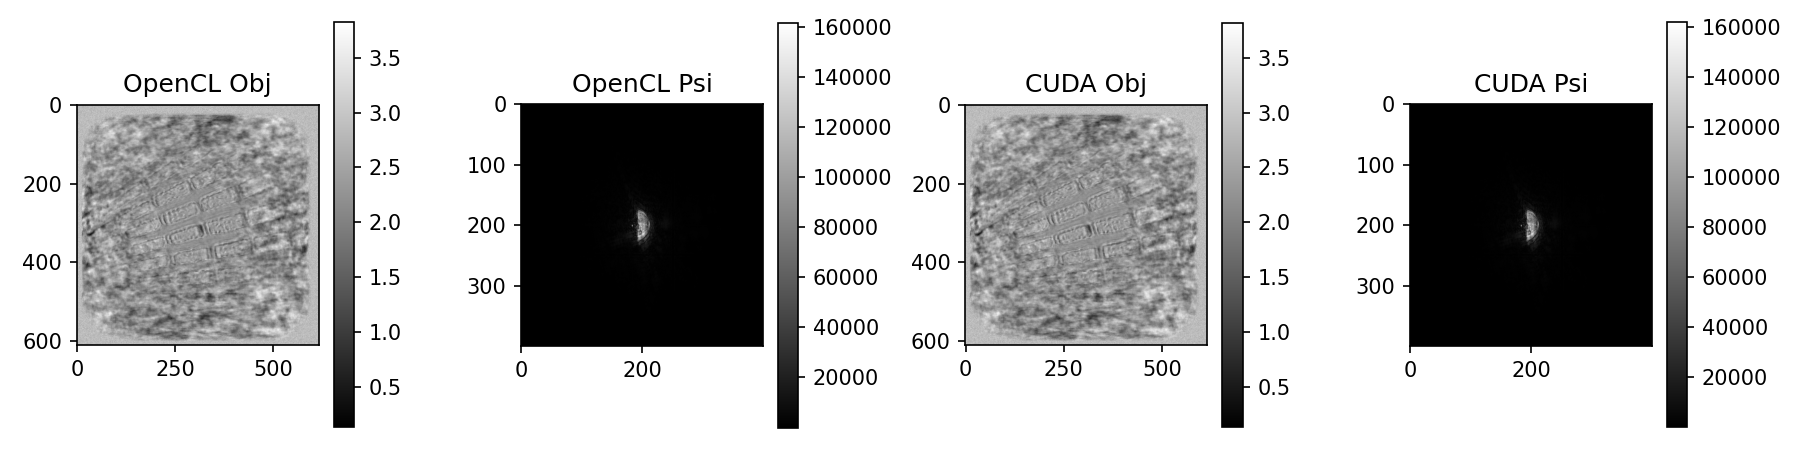

True
True


In [25]:
plt.figure(figsize=(12,3))

p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.AP(update_object=True, update_probe=True) * p
plt.subplot(141)
plt.imshow(abs(p._cl_obj.get()[0]), cmap='gray')
plt.title('OpenCL Obj')
plt.colorbar()
plt.subplot(142)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])), cmap='gray')
plt.title('OpenCL Psi')
plt.colorbar()

# CUDA
p = cuop.AP(update_object=True, update_probe=True) * p
plt.subplot(143)
plt.imshow(abs(p._cu_obj.get()[0]), cmap='gray')
plt.title('CUDA Obj')
plt.colorbar()
plt.subplot(144)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])), cmap='gray')
plt.title('CUDA Psi')
plt.colorbar()

atol = np.abs(p._cu_obj.get()).max() * 1e-4
print(np.allclose(p._cl_obj.get(), p._cu_obj.get(), atol=atol, rtol=1e-4))
atol = np.abs(p._cu_psi.get()).max() * 1e-4
print(np.allclose(p._cl_psi.get(), p._cu_psi.get(), atol=atol, rtol=1e-4))

if False:
    # CPU
    p = cpuop.Psi2ObjProbe(True,True) * cpuop.PropagateApplyAmplitude() * cpuop.ObjProbe2Psi() * p
    plt.subplot(133)
    plt.imshow(abs(p._psi[0,0,0]), cmap='gray')
    plt.title('CPU Psi')
    plt.colorbar()

plt.tight_layout()

## DM**2

<IPython.core.display.Javascript object>


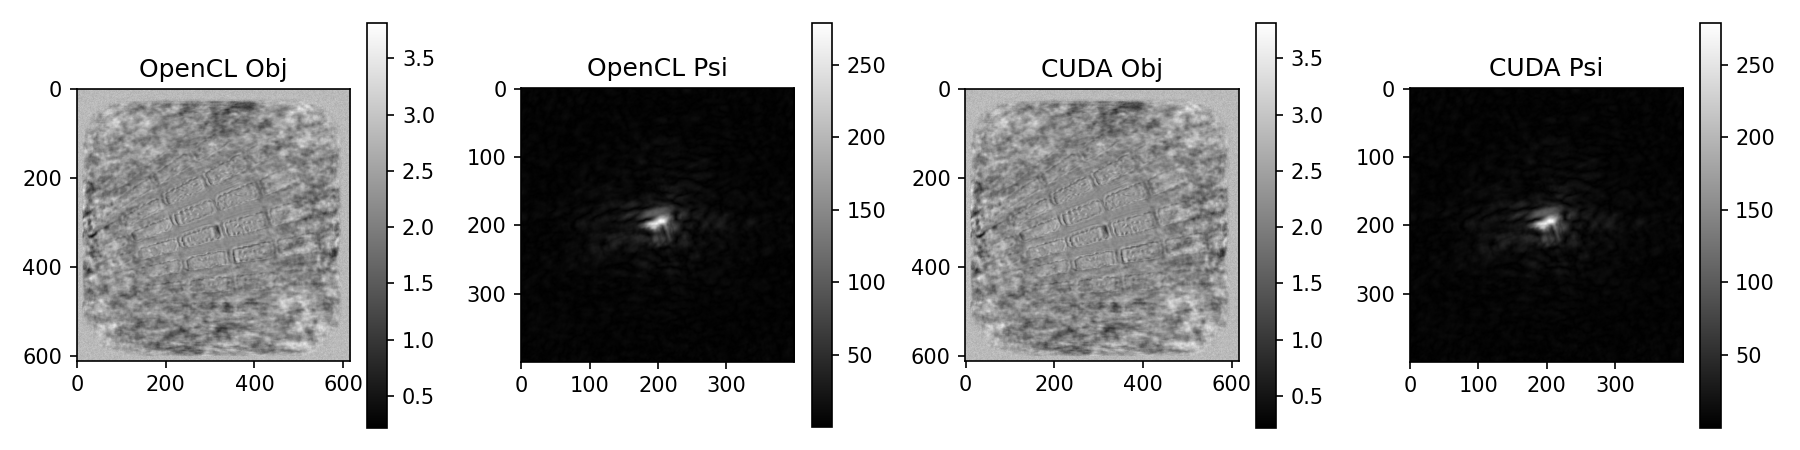

True
True


In [27]:
plt.figure(figsize=(12,3))

p.set_probe(probe)
p.set_obj(obj)
# OpenCL
p = clop.DM(update_object=True, update_probe=True)**2 * p
plt.subplot(141)
plt.imshow(abs(p._cl_obj.get()[0]), cmap='gray')
plt.title('OpenCL Obj')
plt.colorbar()
plt.subplot(142)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])), cmap='gray')
plt.title('OpenCL Psi')
plt.colorbar()

# CUDA
p = cuop.DM(update_object=True, update_probe=True)**2 * p
plt.subplot(143)
plt.imshow(abs(p._cu_obj.get()[0]), cmap='gray')
plt.title('CUDA Obj')
plt.colorbar()
plt.subplot(144)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])), cmap='gray')
plt.title('CUDA Psi')
plt.colorbar()

atol = np.abs(p._cu_obj.get()).max() * 1e-4
print(np.allclose(p._cl_obj.get(), p._cu_obj.get(), atol=atol, rtol=1e-4))
atol = np.abs(p._cu_psi.get()).max() * 1e-4
print(np.allclose(p._cl_psi.get(), p._cu_psi.get(), atol=atol, rtol=1e-4))

if False:
    # CPU
    p = cpuop.Psi2ObjProbe(True,True) * cpuop.PropagateApplyAmplitude() * cpuop.ObjProbe2Psi() * p
    plt.subplot(133)
    plt.imshow(abs(p._psi[0,0,0]), cmap='gray')
    plt.title('CPU Psi')
    plt.colorbar()

plt.tight_layout()

## ML**10

<IPython.core.display.Javascript object>


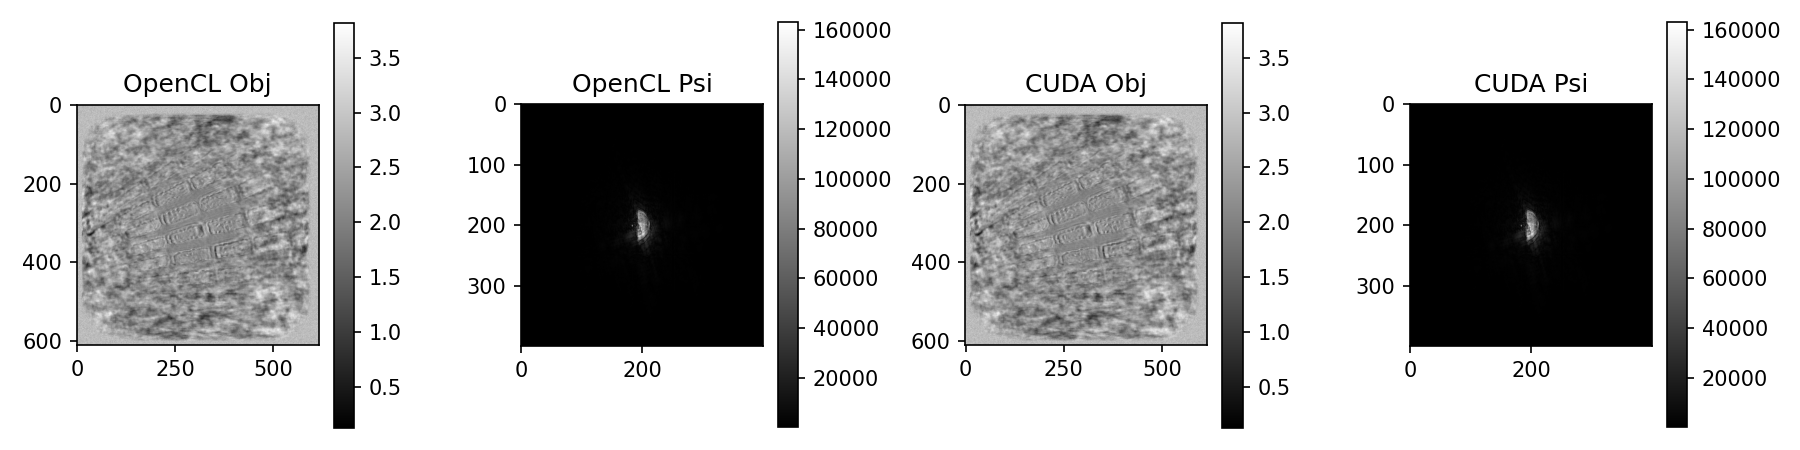

True
True
False


<IPython.core.display.Javascript object>


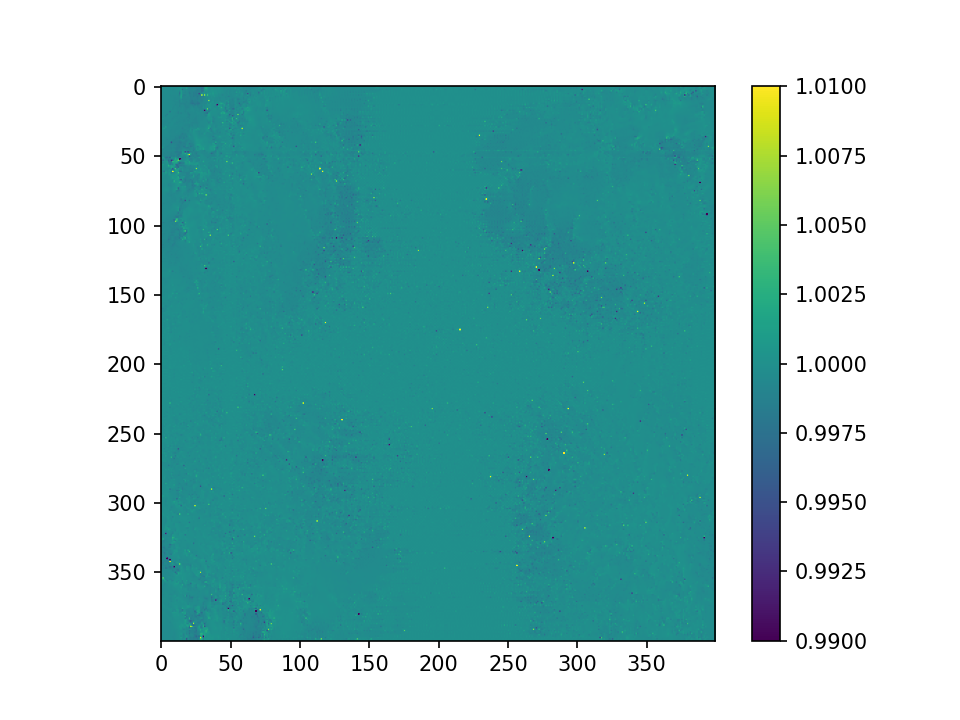

In [30]:
plt.figure(figsize=(12,3))

# OpenCL
p.set_probe(probe)
p.set_obj(obj)
p = clop.ML(update_object=True, update_probe=True)**2 * p
plt.subplot(141)
plt.imshow(abs(p._cl_obj.get()[0]), cmap='gray')
plt.title('OpenCL Obj')
plt.colorbar()
plt.subplot(142)
plt.imshow(fftshift(abs(p._cl_psi.get()[0,0,0])), cmap='gray')
plt.title('OpenCL Psi')
plt.colorbar()

# CUDA
p.set_probe(probe)
p.set_obj(obj)
p = cuop.ML(update_object=True, update_probe=True)**2 * p
plt.subplot(143)
plt.imshow(abs(p._cu_obj.get()[0]), cmap='gray')
plt.title('CUDA Obj')
plt.colorbar()
plt.subplot(144)
plt.imshow(fftshift(abs(p._cu_psi.get()[0,0,0])), cmap='gray')
plt.title('CUDA Psi')
plt.colorbar()

# ML
atol = np.abs(p._cu_obj.get()).max() * 1e-3
print(np.allclose(p._cl_obj.get(), p._cu_obj.get(), atol=atol, rtol=1e-3))
atol = np.abs(p._cu_obj.get()).max() * 1e-4
print(np.allclose(p._cl_probe.get(), p._cu_probe.get(), atol=atol, rtol=1e-4))
atol = np.abs(p._cu_psi.get()).max() * 1e-4
print(np.allclose(p._cl_psi.get(), p._cu_psi.get(), atol=atol, rtol=1e-4))

if False:
    # CPU
    p = cpuop.Psi2ObjProbe(True,True) * cpuop.PropagateApplyAmplitude() * cpuop.ObjProbe2Psi() * p
    plt.subplot(133)
    plt.imshow(abs(p._psi[0,0,0]), cmap='gray')
    plt.title('CPU Psi')
    plt.colorbar()

plt.tight_layout()
plt.figure()
plt.imshow(abs(p._cu_psi.get()[0,0,0]/p._cl_psi.get()[0,0,0]),vmin=0.99,vmax=1.01)
plt.colorbar()